In [1]:
import os
import numpy as np 
import pandas as pd 
import glob
import cv2
import torch
from tqdm import tqdm

In [2]:
df_train = pd.read_csv('/kaggle/input/shift-cv-winter-2023/train.csv')
print(len(df_train))

2664


In [3]:
path = '/kaggle/input/shift-cv-winter-2023/train/train/'

df_train['filename'] = df_train['filename'].apply(lambda x: path + x)
df_train.head()

,filename,blur
0,/kaggle/input/shift-cv-winter-2023/train/train...,0.0
1,/kaggle/input/shift-cv-winter-2023/train/train...,0.0
2,/kaggle/input/shift-cv-winter-2023/train/train...,0.0
3,/kaggle/input/shift-cv-winter-2023/train/train...,0.0
4,/kaggle/input/shift-cv-winter-2023/train/train...,1.0


In [4]:
def variance_of_laplacian(path_img):
    img = cv2.imread(path_img)
    image_grey=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Laplacian(image_grey, cv2.CV_64F).var()

In [5]:
lap_measures = []

for i in range(len(df_train)):
    lap_measures.append(variance_of_laplacian(df_train.iloc [i]['filename']))
    
df_train['lap_measures'] = lap_measures 

#df_train[df_train["blur"]==0].head(10)
#df_train['filename'].head()

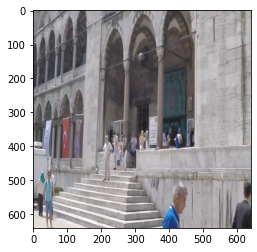

33.934245553916696


In [6]:
from matplotlib import pyplot as plt
#df_train.head()
df_train[df_train["blur"]==1].head()
img = plt.imread(df_train.iloc [0]['filename'])
plt.imshow(img)
plt.show()

print(variance_of_laplacian(df_train.iloc [4]['filename']))


In [7]:
test_imgs = []
for file in glob.glob("/kaggle/input/shift-cv-winter-2023/test/test/*.jpg"):
    test_imgs.append({'filename': file})
df_test = pd.DataFrame(test_imgs)
print("Test images: ", len(df_test))

Test images:  774


In [8]:
train_blur = df_train[df_train["blur"]==1]
train_sharp = df_train[df_train["blur"]==0]

print("blur images:", len(train_blur))
print("sharp images:", len(train_sharp))

blur images: 1297
sharp images: 1367


In [9]:
def read_image_gray(path):
    return cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2GRAY)

In [10]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, df):
        self.df = df
               
    def __len__(self):
        return len(self.df)


class CustomDatasetTrain(CustomDataset):
    def __init__(self, df, transform=None):
        super().__init__(df)
        self.transform = transform
   
    def __getitem__(self,idx):
        image = self.df.filename.iloc[idx]
        image = read_image_gray(image)
        if self.transform:
            image = self.transform(image)
        label = self.df.blur.iloc[idx]
        return {'image': image, 'label': label}


class CustomDatasetTest(CustomDataset):
    def __getitem__(self,idx):
        image = self.df.filename.iloc[idx]
        image = read_image_gray(image)
        return {'image': image}

In [11]:
train_dataset = CustomDatasetTrain(df_train)

train_dataloader = DataLoader(
            dataset=train_dataset,
            batch_size=16,
            ),

In [12]:
def calc_fft_measure(gray_img, size=40):
    (n, h, w) = gray_img.shape
    (cx, cy) = (int(w / 2.0), int(h / 2.0))
    fft = np.fft.fft2(gray_img, axes=(1, 2))
    fftShift = np.fft.fftshift(fft, axes=(1, 2))

    fftShift[:, cy - size : cy + size, cx - size : cx + size] = 0
    fftShift = np.fft.ifftshift(fftShift, axes=(1, 2))
    recon = np.fft.ifft2(fftShift, axes=(1, 2))
    
    magnitude = 20 * np.log(np.abs(recon))
    mean = 1/np.average(magnitude, axis=(1, 2))

    return mean

In [13]:
def calc_tv_measure(gray_img):

    gray_img = gray_img.detach().clone()
    gray_img = gray_img[:, gray_img.shape[1]//4:3*gray_img.shape[1]//4,gray_img.shape[2]//4:3*gray_img.shape[2]//4]
    
    w_variance = torch.sum(torch.pow(gray_img[:, :, 1:] - gray_img[:, :, :-1], 2), dim=[1, 2])
    h_variance = torch.sum(torch.pow(gray_img[:, 1:, :] - gray_img[:, :-1, :], 2), dim=[1, 2])

    l2_score = (h_variance + w_variance)

    w_variance = torch.sum(torch.abs(gray_img[:, :, 1:] - gray_img[:, :, :-1]), dim=[1, 2])
    h_variance = torch.sum(torch.abs(gray_img[:, 1:, :] - gray_img[:, :-1, :]), dim=[1, 2])
    
    l1_score = (h_variance + w_variance)
    
    tv_measure = l1_score/l2_score
    
    return tv_measure

In [14]:
tv_measures = []
fft_measures = []

for dl in train_dataloader:
    for batch in tqdm(dl):
        tv_measures.extend(calc_tv_measure(batch['image']).tolist())
        fft_measures.extend(calc_fft_measure(batch['image']).tolist())
df_train['tv_measure'] = tv_measures
df_train['fft_measure'] = fft_measures  

df_train.head()

100%|██████████| 167/167 [02:23<00:00,  1.16it/s]


,filename,blur,lap_measures,tv_measure,fft_measure
0,/kaggle/input/shift-cv-winter-2023/train/train...,0.0,403.814067,4.340060,0.027601
1,/kaggle/input/shift-cv-winter-2023/train/train...,0.0,884.459052,2.989293,0.025317
2,/kaggle/input/shift-cv-winter-2023/train/train...,0.0,362.737453,4.313049,0.033126
3,/kaggle/input/shift-cv-winter-2023/train/train...,0.0,219.264783,5.828151,0.040531
4,/kaggle/input/shift-cv-winter-2023/train/train...,1.0,33.934246,5.371748,0.054616


**Добавим больше данных**

Метод отклонения

Тененградский градиентный метод


In [15]:
def mean_Std_Dev(path_img):
    img = cv2.imread(path_img)
    img_gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    mean = cv2.meanStdDev(img_gray)
    return mean

def variance_of_Sobol(path_img):
    img = cv2.imread(path_img)
    img_gray=cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    return cv2.Sobel(img_gray,cv2.CV_64F,1,1).var()

In [16]:
Sobol_measures = []

for i in range(len(df_train)):
    Sobol_measures.append(variance_of_Sobol(df_train.iloc [i]['filename']))
    
df_train['Sobol_measures'] = Sobol_measures 

In [17]:
mean_measures = []
stddev_measures = []

for i in range(len(df_train)):
    mean_std =[]
    mean_std = mean_Std_Dev(df_train.iloc [i]['filename'])
    mean_measures.append(mean_std [0][0][0])
    stddev_measures.append(mean_std[1][0][0])
    
df_train['mean_measures'] = mean_measures 
df_train['stddev_measures'] = stddev_measures

In [18]:
features =['lap_measures','tv_measure','fft_measure','Sobol_measures','mean_measures','stddev_measures']
X_train = df_train[features]
y_train = df_train['blur'] 

**Созданеи тестовых данных**

In [19]:
lap_measures = []

for i in range(len(df_test)):
    lap_measures.append(variance_of_laplacian(df_test.iloc [i]['filename']))
    
df_test['lap_measures'] = lap_measures 


In [20]:
Sobol_measures = []

for i in range(len(df_test)):
    Sobol_measures.append(variance_of_Sobol(df_test.iloc[i]['filename']))
    
df_test['Sobol_measures'] = Sobol_measures 

In [21]:
mean_measures = []
stddev_measures = []

for i in range(len(df_test)):
    mean_std =[]
    mean_std = mean_Std_Dev(df_test.iloc [i]['filename'])
    mean_measures.append(mean_std [0][0][0])
    stddev_measures.append(mean_std[1][0][0])
    
df_test['mean_measures'] = mean_measures 
df_test['stddev_measures'] = stddev_measures

In [22]:
test_dataset = CustomDatasetTest(df_test)
test_dataloader = DataLoader(dataset=test_dataset, batch_size=16),

tv_measures = []
fft_measures = []

for dl in test_dataloader:
    for batch in tqdm(dl):
        tv_measures.extend(calc_tv_measure(batch['image']).tolist())
        fft_measures.extend(calc_fft_measure(batch['image']).tolist())
        
df_test['tv_measure'] = tv_measures
df_test['fft_measure'] = fft_measures  

df_test.head()

100%|██████████| 49/49 [00:41<00:00,  1.18it/s]


,filename,lap_measures,Sobol_measures,mean_measures,stddev_measures,tv_measure,fft_measure
0,/kaggle/input/shift-cv-winter-2023/test/test/s...,590.694200,391.261704,125.267349,51.671799,3.117185,0.026317
1,/kaggle/input/shift-cv-winter-2023/test/test/m...,18.715744,8.441822,87.966960,62.974327,11.831388,0.090741
2,/kaggle/input/shift-cv-winter-2023/test/test/a...,366.014348,217.556695,94.715386,69.625136,3.895545,0.032686
3,/kaggle/input/shift-cv-winter-2023/test/test/q...,21.395315,13.697021,98.465454,43.544982,6.882382,0.062959
4,/kaggle/input/shift-cv-winter-2023/test/test/l...,307.438624,157.736786,139.741340,48.286316,3.712345,0.028509


In [23]:
features =['lap_measures','tv_measure','fft_measure','Sobol_measures','mean_measures','stddev_measures']
X_test = df_test[features]

**Модель построенная на RFC с использованием GridSearchCV**

In [24]:
from sklearn.preprocessing import StandardScaler
ss = StandardScaler()
X_train_scaled = ss.fit_transform(X_train)
X_test_scaled = ss.transform(X_test)
y_train = np.array(y_train)

In [25]:
forrest_params = dict(     
    max_depth = [n for n in range(9, 14)],     
    min_samples_split = [n for n in range(4, 11)], 
    min_samples_leaf = [n for n in range(2, 5)],     
    n_estimators = [n for n in range(10, 60, 10)],
)

In [26]:
from sklearn.ensemble import RandomForestClassifier
# instantiate Random Forest model
forrest = RandomForestClassifier()

In [27]:
from sklearn.model_selection import GridSearchCV
# build and fit model 
forest_cv = GridSearchCV(estimator=forrest,     param_grid=forrest_params, cv=5) 
forest_cv.fit(X_train_scaled, y_train)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': [9, 10, 11, 12, 13],
                         'min_samples_leaf': [2, 3, 4],
                         'min_samples_split': [4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [10, 20, 30, 40, 50]})

In [28]:
print("Best score: {}".format(forest_cv.best_score_))
print("Optimal params: {}".format(forest_cv.best_estimator_))

Best score: 0.9624617359533918
Optimal params: RandomForestClassifier(max_depth=11, min_samples_leaf=2, min_samples_split=5,
                       n_estimators=30)


In [29]:
forrest_pred = forest_cv.predict(X_test_scaled)

**Выгрузка изображений**

In [30]:
df_test_rfc = pd.DataFrame()
df_test_rfc['filename'] = df_test['filename'].apply(lambda x : os.path.split(x)[1])
df_test_rfc['blur'] = forrest_pred
# save to csv
df_test_rfc.to_csv('/kaggle/working/submission.csv', index=False)